In [1]:
import typing
import os.path as op
import anaconfig

from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import montetracko.lhcb as mtb
import matplotlib as mpl

from utils.loaderutils.preprocessing import load_dataframes
from utils.plotutils.plotconfig import configure_matplotlib
from utils.plotutils.plotools import save_fig
from Processing.planewise_edges import get_planewise_edges
from Preprocessing.particle_fitting_metrics import compute_particle_line_metrics_dataframe

configure_matplotlib()

In [2]:
plotdir = op.join(anaconfig.PLOTDIR, "scifi")

In [3]:
df_hits_particles, df_particles = load_dataframes(
    indir="/scratch/acorreia/minbias-sim10b-xdigi/2/",
    particles_filename="mc_particles",
    hits_particles_filename="hits_scifi",
)
df_hits_particles["fake"] = df_hits_particles["particle_id"] == 0

plane_groups = df_hits_particles.groupby(["event_id", "particle_id"])["plane"]
diff_planes = plane_groups.max() - plane_groups.min()

df_hits_particles = df_hits_particles.merge(
    diff_planes.rename("plane_diff").reset_index(),
    how="left",
    on=["event_id", "particle_id"],
)


In [4]:
from numpy.polynomial.polynomial import Polynomial
from Preprocessing.particle_poly_fitting import fit_poly, eval_polynomial
from Preprocessing.particle_line_metrics import compute_distance_to_poly

def plot_xz_graph(
    df_hits_particles: pd.DataFrame,
    n_tracks: int,
    n_events: int = 10,
    seed: int | None = None,
    remove_tilted: bool = True,
    polyfit: bool = False,
):
    fig, ax = plt.subplots(figsize=(8, 6))

    event_ids = df_hits_particles["event"].unique()

    rng = np.random.default_rng(seed=seed)
    rng.shuffle(event_ids)

    if remove_tilted:
        df_hits_particles = df_hits_particles[df_hits_particles["dxdy"] == 0.0]

    for idx, (_, hits_particle) in enumerate(
        df_hits_particles[
            df_hits_particles["event"].isin(event_ids[:n_events])
            & (df_hits_particles["particle_id"] != 0)
        ].groupby(by=["event", "particle_id"])
    ):
        hit_coordinates = hits_particle.sort_values(by="plane")

        lines = ax.plot(
            hit_coordinates["zatyeq0"],
            hit_coordinates["xatyeq0"],
            linestyle="" if polyfit else "-",
            markersize=5.0,
            marker="o",
        )
        if polyfit:
            not_tilted_hit_coordinates = hit_coordinates[hit_coordinates["dxdy"] == 0.0]
            # polynomial = Polynomial.fit(
            #     x=not_tilted_hit_coordinates["zatyeq0"],
            #     y=not_tilted_hit_coordinates["xatyeq0"],
            #     deg=2,
            # )
            # ax.plot(
            #     *polynomial.linspace(
            #         n=100,
            #         domain=[
            #             hit_coordinates["zatyeq0"].min(),
            #             hit_coordinates["zatyeq0"].max(),
            #         ],
            #     ),
            #     linestyle="--",
            #     color=lines[0].get_color(),
            # )
            x = not_tilted_hit_coordinates["zatyeq0"].to_numpy()
            y = not_tilted_hit_coordinates["xatyeq0"].to_numpy()
            coeffs = fit_poly(x=x, y=y, deg=2)
            x_fine = np.linspace(x.min(), x.max(), num=100, endpoint=True)
            y_fine = eval_polynomial(coeffs, x_fine)
            ax.plot(
                x_fine,
                y_fine,
                linestyle="--",
                color=lines[0].get_color(),
            )
            fitted_y = eval_polynomial(coeffs, x)
            print(
                np.sqrt(np.sum(np.square(fitted_y - y))) / (x.shape[0] - 3),
            )
        if idx >= n_tracks - 1:
            break

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_xlim(
        (
            df_hits_particles["zatyeq0"].min() - 100,
            df_hits_particles["zatyeq0"].max() + 100,
        )
    )
    ax.set_ylim(
        (df_hits_particles["xatyeq0"].min() - 100, df_hits_particles["xatyeq0"].max() + 100)  # type: ignore
    )
    return fig

In [5]:
df_hits_particles_genuine = df_hits_particles[
    df_hits_particles["particle_id"] != 0
].merge(
    df_particles[["event_id", "particle_id", "has_scifi", "nhits_scifi"]],
    on=["event_id", "particle_id"],
    how="left",
)

In [6]:
df_hits_particles_genuine_cat = df_hits_particles_genuine[
    df_hits_particles_genuine["has_scifi"]
]

In [10]:
particles_planes_groups = df_hits_particles_genuine_cat.groupby(
    ["event_id", "particle_id", "plane"]
)

xmins = particles_planes_groups["xatyeq0"].min().rename("xmin")
xmaxs = particles_planes_groups["xatyeq0"].max().rename("xmax")

nshareds = particles_planes_groups["xatyeq0"].count()

In [11]:
xdiffs = xmaxs - xmins
xdiffs 

event_id           particle_id  plane
17200668000800857  437          0        0.0
                                1        0.0
                                2        0.0
                                3        0.0
                                4        0.0
                                        ... 
17224051004729368  1134         7        0.0
                                8        0.0
                                9        0.0
                                10       0.0
                                11       0.0
Length: 2099613, dtype: float64

Text(0, 0.5, 'Max distance within plane')

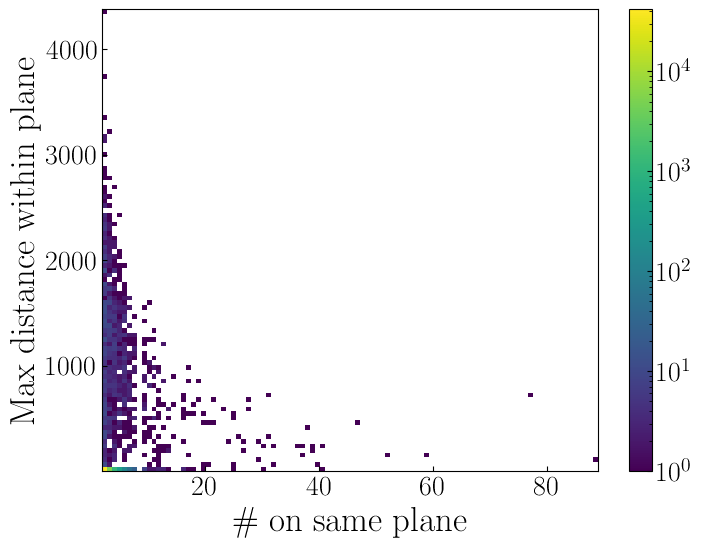

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.hist2d(
    x=nshareds[nshareds > 1],
    y=xdiffs[nshareds > 1],
    bins=100,
    norm=mpl.colors.LogNorm(),
)[-1]
fig.colorbar(im, ax=ax)
ax.set_xlabel("\\# on same plane")
ax.set_ylabel("Max distance within plane")

In [12]:
df_weird = df_hits_particles_genuine_cat.merge(
    xdiffs.rename("plane_xdiff").reset_index(),
    how="left",
    on=["event_id", "particle_id", "plane"],
)

In [13]:
max_xdiffs = xdiffs.groupby(["event_id", "particle_id"]).max()

In [40]:
max_xdiffs[(max_xdiffs > 50) & (max_xdiffs < 60)]

event_id           particle_id
17215691003324781  2739           52.128
17215691003324813  3539           57.399
17215691003324831  3458           51.880
dtype: float64

In [41]:
(max_xdiffs < 2.5).sum() / max_xdiffs.shape[0]

0.9916793028131621

6.577732001096686
8.734974857907828
1.235001269534457
7.764066596000214
0.11670398650603553
0.4760856759814219
0.04799585836668749
0.680202795140374
2.2830699318109953
3.3671957687435468
1.171828422901917
0.43559912713800375
0.08942849179407769
0.7881979691616291
0.32971967395045987
3.8631559304287775
0.42689399152010665
0.5573533391449187
0.6563535431812323
2.280048403841635


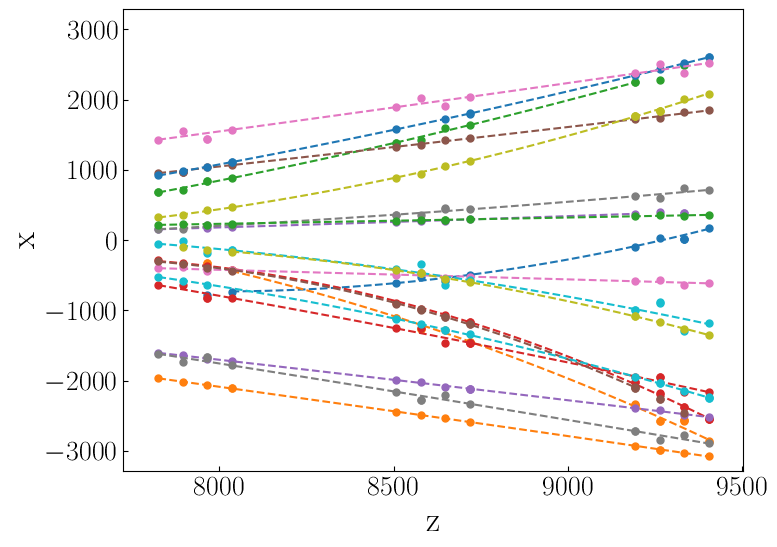

In [42]:
plot_xz_graph(
    df_hits_particles_genuine_cat.merge(
        max_xdiffs[(max_xdiffs < 2.5) & (max_xdiffs > 1.0)].reset_index()[
            ["event_id", "particle_id"]
        ],
        on=["event_id", "particle_id"],
        how="inner",
    ),
    n_tracks=20,
    n_events=2000,
    remove_tilted=False,
    polyfit=True,
);

## Distances

In [14]:
df_hits_particles_genuine_cat = df_hits_particles_genuine_cat.merge(
    max_xdiffs[max_xdiffs < 2.5].reset_index()[["event_id", "particle_id"]],
    on=["event_id", "particle_id"],
    how="inner",
)

In [15]:
distances = compute_particle_line_metrics_dataframe(
    df_hits_particles_genuine_cat[df_hits_particles_genuine_cat["dxdy"] == 0.0],
    metric_names=["distance_to_poly"],
    coord_names=["zatyeq0", "xatyeq0"],
)

In [16]:
distances = distances["distance_to_poly"]

Text(0, 0.5, '\\# particles')

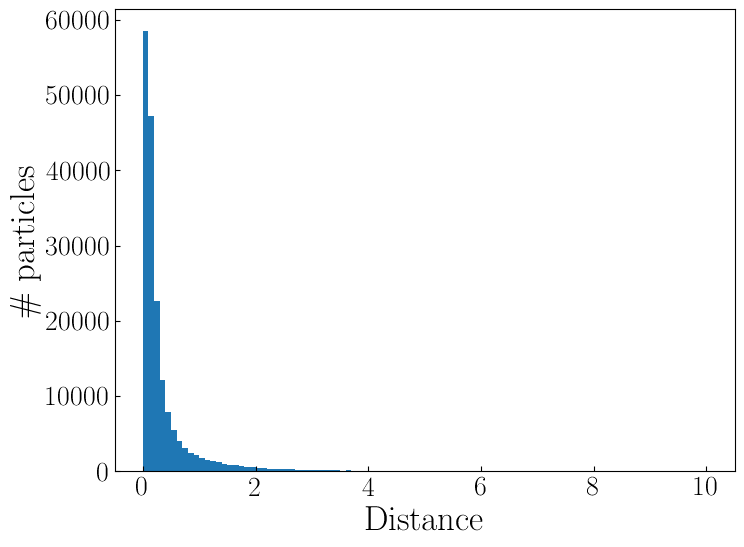

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(distances, density=False, range=(0, 10), bins=100)
ax.set_xlabel("Distance")
ax.set_ylabel("\\# particles")


In [18]:
distances_augmented = distances.reindex(
    df_hits_particles.groupby(["event_id", "particle_id"]).count().index,
    fill_value=0.0
)

In [25]:
max_dist = 70
(distances_augmented < max_dist).sum() / distances_augmented.shape[0]


0.9999613429104739

76.10570449301204
79.40559277339142
60.38283606451095
70.66191369726806
78.71444326231052
85.12489565097754
85.86088272688146
60.264132254759296
81.03007366908905
77.18600996452037


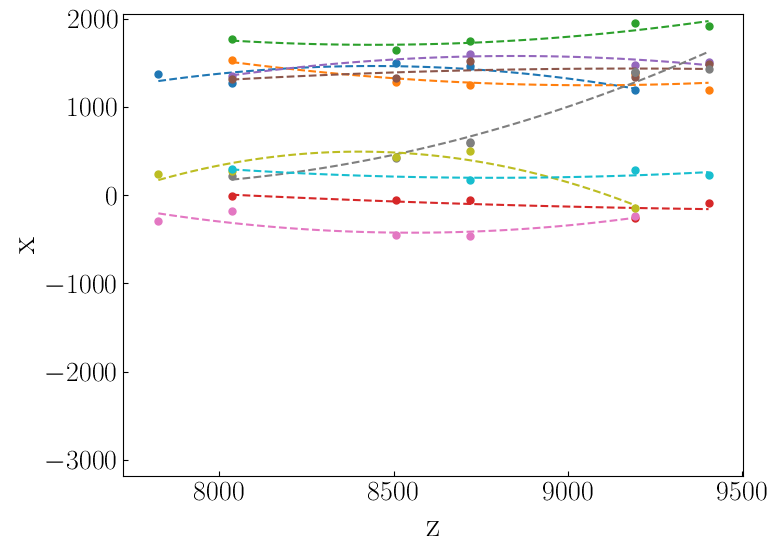

In [24]:
df_weird = df_hits_particles_genuine_cat.merge(
    distances[(distances > max_dist) & (distances < max_dist * 1.5)].reset_index()[
        ["event_id", "particle_id"]
    ],
    on=["event_id", "particle_id"],
    how="inner",
)

plot_xz_graph(
    df_weird[df_weird["plane_diff"] > 8],
    n_tracks=10,
    n_events=2000,
    remove_tilted=True,
    polyfit=True,
);